In [1]:
# --- Initialisation ---
import os
import sys
import pandas as pd
import numpy as np
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import recall_score, make_scorer, ConfusionMatrixDisplay


# --- Accès au dossier contenant utils.py ---
sys.path.append(os.path.abspath(".."))
from utils import execute_model_and_save_score, execute_model

# --- Chargement des données AU CHOIX ---
# DF_PATH = "../data/cardio_optimized.csv"
# DF_PATH = "../data/cardio_light.csv"
DF_PATH = "../data/balanced.csv"

df = pd.read_csv(DF_PATH, sep=";")

# --- Séparation des features et de la cible ---
X = df.drop(columns=["cardio"])
y = df["cardio"]


# 1. Créer un scorer personnalisé pour le recall de la classe 1
recall_scorer = make_scorer(
    recall_score, 
    pos_label=1  # Spécifie que la classe 1 est la classe positive
)

model = LogisticRegression()


#### `LogisticRegression` avec `GridSearchCV`
Recherche et stockage des meilleurs hyperparamètres dans `best_model_grid`

In [2]:
from collections import Counter

# Calcul du poids pour les classes
counter = Counter(y)
n0, n1 = counter[0], counter[1]
manual_weight = {0: 1, 1: round(n0 / n1, 2)}
print("🧮 Poids manuel calculé :", manual_weight)


🧮 Poids manuel calculé : {0: 1, 1: 1.04}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# param_grid = {
#     'C': [50, 100, 150, 200],
#     'penalty': ['l2', 'l1', 'elasticnet'],  # ou 'l1' si le solver le permet
#     'solver': ['liblinear', 'lbfgs', 'saga'],
#     'max_iter': [1000],
#     'class_weight':  [
#         None,
#         'balanced',
#         {0: 1, 1: 2},
#         {0: 1, 1: 3}
#     ]
# }

param_grid = [
    {
        'penalty': ['l2'],
        'solver': ['liblinear'],
        'C': [50, 100],
        'class_weight': ['balanced', manual_weight],
        'max_iter': [1000]
    },
    # {
    #     'penalty': ['l1'],
    #     'solver': ['liblinear'],
    #     'C': [50, 100],
    #     'class_weight': ['balanced', manual_weight],
    #     'max_iter': [1000]
    # },
    {
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'C': [50, 100],
    'l1_ratio': [0.3, 0.5, 0.7],  # obligatoire pour elasticnet
    'class_weight': ['balanced', manual_weight],
    'max_iter': [1000]
    }
]


grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring=recall_scorer
)

# Ne refais pas le fit si déjà fait
if "best_model_grid" not in globals():
    grid_search.fit(X_train, y_train)
    best_model_grid = grid_search.best_estimator_
    print("✅ Grid search terminée.")
else:
    print("✅ Modèle déjà entraîné : utilisation de best_model.")

# Sauvegarde
joblib.dump(best_model_grid, "best_model_logreg.joblib")

print("Meilleurs estimateurs trouvés :", grid_search.best_estimator_)
print("Meilleurs hyperparamètres trouvés :", grid_search.best_params_)
print("Meilleur score d'entraînement :", grid_search.best_score_)



c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which 

✅ Grid search terminée.
Meilleurs estimateurs trouvés : LogisticRegression(C=50, class_weight={0: 1, 1: 1.04}, l1_ratio=0.5,
                   max_iter=1000, penalty='elasticnet', solver='saga')
Meilleurs hyperparamètres trouvés : {'C': 50, 'class_weight': {0: 1, 1: 1.04}, 'l1_ratio': 0.5, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
Meilleur score d'entraînement : 0.7613526570048309


c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### `LogisticRegression` avec `RandomizedSearchCV`
Recherche et stockage des meilleurs hyperparamètres dans `best_model_radom`

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

param_distributions = {
    'C':  [150, 200], # C variera de 0.01 à 100, selon une distribution log-uniforme
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [500]
}

randomized_search = RandomizedSearchCV(
    estimator = model,
    param_distributions=param_distributions,  # ou param_grid si tu préfères, mais param_distributions est la convention
    cv=5,
    scoring=recall_scorer,  # Optimise spécifiquement le recall de la classe 1
    n_iter=5,  # Ici, 2 car tu n'as que 2 valeurs pour C, mais à adapter selon ton espace de paramètres
    random_state=42
                           )

# 2. Lancer l'entraînement avec .fit(), Ne relance pas le fit si déjà effectué
if "best_model_random" not in globals():
    randomized_search.fit(X_train, y_train)
    best_model_random = randomized_search.best_estimator_
    print("✅ Randomized search terminée.")
else:
    print("✅ Modèle aléatoire déjà entraîné : utilisation de best_model_random.")

# Sauvegarde sur disque
joblib.dump(best_model_random, "best_model_random_logreg.joblib")


print("Meilleurs hyperparamètres trouvés :", randomized_search.best_params_ if "randomized_search" in globals() else best_model_random.get_params())
print("Meilleur score d'entraînement (recall classe 1) :", randomized_search.best_score_ if "randomized_search" in globals() else "déjà calculé")

c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO.

✅ Randomized search terminée.
Meilleurs hyperparamètres trouvés : {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 500, 'C': 200}
Meilleur score d'entraînement (recall classe 1) : 0.6721553202957855


c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Execution du modele

In [13]:
# Chargement des meilleurs paramètre de GridSearchCV 
best_model_grid = joblib.load("best_model_logreg.joblib")
# et RandomSearchCV
best_model_random = joblib.load("best_model_random_logreg.joblib")

In [5]:

# ============== EXECUTION de modèles et ENREGISTREMENT des métriques ================

# execute_model_and_save_score(X, y)
# execute_model_and_save_score(X, y, max_iter=1000, penalty="l2", solver="lbfgs")
# execute_model_and_save_score(X, y, max_iter=2000, penalty="l2", solver="lbfgs")
# execute_model_and_save_score(X, y, max_iter=2000, solver="lbfgs")
# execute_model_and_save_score(X, y, df_path=DF_PATH, max_iter=2000)
# execute_model_and_save_score(X, y, df_path=DF_PATH, penalty="l2", solver="lbfgs", max_iter=2000)
# execute_model_and_save_score(X, y, df_path=DF_PATH, penalty='l1', solver='liblinear')
# execute_model_and_save_score(X, y, df_path=DF_PATH, penalty='l1', solver='saga')
# execute_model_and_save_score(X, y, df_path=DF_PATH, penalty='l2', solver='newton-cg')
# execute_model_and_save_score(X, y, max_iter=2000, df_path=DF_PATH, penalty='l2', solver='newton-cg')
# execute_model_and_save_score(X, y, C= 100, max_iter=1000, penalty= 'l2', solver= 'liblinear', df_path = DF_PATH)
# execute_model_and_save_score(X, y, C= 200, max_iter= 1000, penalty= 'l2', solver= 'liblinear', df_path = DF_PATH)
# execute_model_and_save_score(X, y, C= 200, max_iter= 1000, penalty= 'l2', solver= 'liblinear', df_path = DF_PATH)
# execute_model_and_save_score(X, y, C= 150, max_iter= 1000, penalty= 'l2', solver= 'liblinear', df_path = DF_PATH)
# execute_model_and_save_score(X, y, C= 200, max_iter= 1000, penalty= 'l2', solver= 'liblinear', df_path = DF_PATH)
# execute_model_and_save_score(X, y, model=best_model_grid)
execute_model_and_save_score(X, y, model=best_model_grid)

✅ Accuracy : 0.6113
📊 Rapport de classification :
               precision    recall  f1-score   support

           0       0.67      0.47      0.55      1609
           1       0.58      0.76      0.66      1553

    accuracy                           0.61      3162
   macro avg       0.62      0.61      0.60      3162
weighted avg       0.62      0.61      0.60      3162

🧱 Matrice de confusion :
 [[ 754  855]
 [ 374 1179]]
Résultat enregistré dans ../results.csv


In [14]:
y_test, y_pred, y_proba, X_test = execute_model(X, y, model=best_model_grid)

✅ Accuracy : 0.6113
📊 Rapport de classification :
               precision    recall  f1-score   support

           0       0.67      0.47      0.55      1609
           1       0.58      0.76      0.66      1553

    accuracy                           0.61      3162
   macro avg       0.62      0.61      0.60      3162
weighted avg       0.62      0.61      0.60      3162
 

🧱 Matrice de confusion :
 [[ 754  855]
 [ 374 1179]] 

Precision :  0.624
Recall :  0.6139
Recall 1 :  0.7592
F 1 :  0.6042


In [15]:
print(np.unique(y_pred, return_counts=True))

(array([0, 1]), array([1128, 2034]))


## Modification du seuil

In [16]:
# Obtenir les probabilités pour la classe 1
y_proba = best_model_grid.predict_proba(X_test)[:, 1]

# Trouver le seuil qui maximise le recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

In [17]:
print(precision, recall, thresholds)

[0.49114485 0.49130022 0.4914557  ... 0.5        1.         1.        ] [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 6.43915003e-04
 6.43915003e-04 0.00000000e+00] [0.43468577 0.43584358 0.43610891 ... 0.6304209  0.63117184 0.63265865]


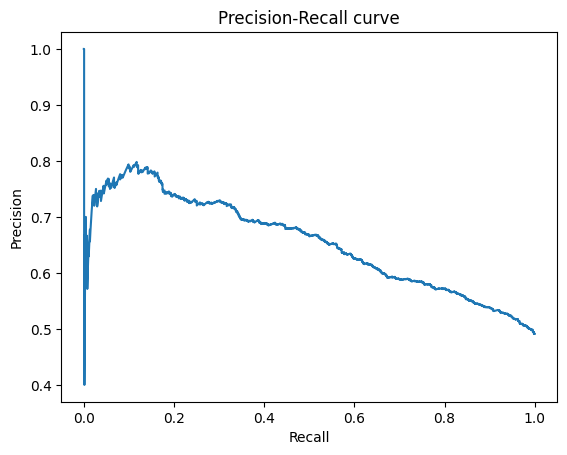

In [18]:
import matplotlib.pyplot as plt

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


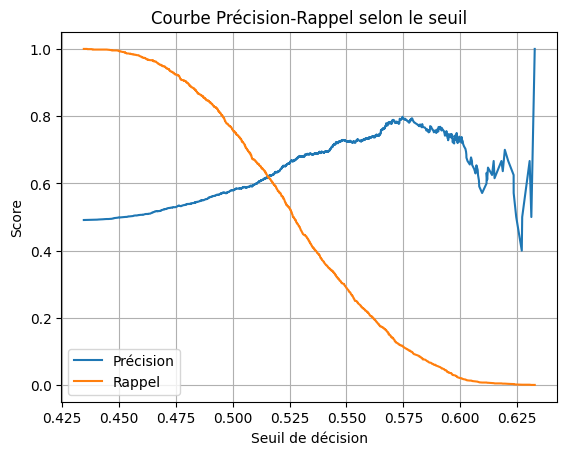

In [11]:
plt.plot(thresholds, precision[:-1], label='Précision')
plt.plot(thresholds, recall[:-1], label='Rappel')
plt.xlabel('Seuil de décision')
plt.ylabel('Score')
plt.legend()
plt.title('Courbe Précision-Rappel selon le seuil')
plt.grid()
plt.show()


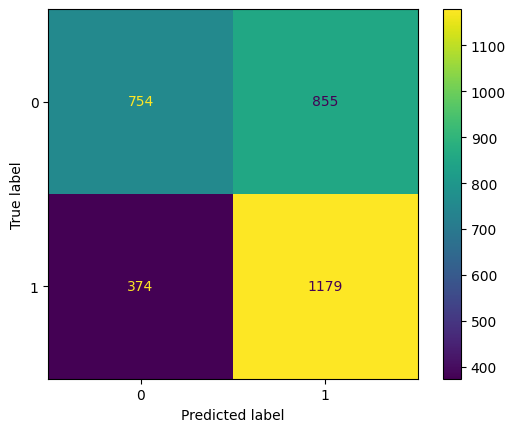

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [13]:
# Exemple : choisir un seuil qui donne un recall élevé (ici, le premier seuil où recall > 0.9)
target_recall = 0.2
# On compare recall[:-1] car thresholds a une valeur de moins que recall
mask = recall[:-1] > target_recall

if mask.any():  # S'il existe un seuil qui donne recall > 0.9
    threshold = thresholds[mask][0]
else:
    print("Aucun seuil ne permet d'atteindre recall >", target_recall)
    threshold = thresholds[-1]  # On prend le dernier seuil disponible

# Prédire avec le nouveau seuil
y_pred = (y_proba >= threshold).astype(int)

# Évaluer les performances
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6926
           1       0.49      1.00      0.66      6787

    accuracy                           0.49     13713
   macro avg       0.25      0.50      0.33     13713
weighted avg       0.24      0.49      0.33     13713



c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera